In [14]:
import pandas as pd
import numpy as np
import librosa
import os
import json
import soundfile as sf
import ffmpeg
import IPython.display as ipd

import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn import preprocessing


In [15]:
sample_sub = pd.read_csv('SampleSubmission.csv')

In [16]:
#defining data paths and neccessary variables
DATA_PATH = "nd.json"
SAVED_MODEL_PATH = "model_nd.h5"
EPOCHS = 240
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [3]:
def load_data(data_path):
    """Loads training dataset from json file.

    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets

    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
#   y= tf.keras.utils.to_categorical(y, 193)
    print("Training sets loaded!")
    return X, y

In [6]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.

    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation

    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """
    
     # load dataset
    X, y = load_data(data_path)


    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

    

In [7]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.

    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):

    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(193, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


In [8]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model

    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set

    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


In [9]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()



Training sets loaded!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None

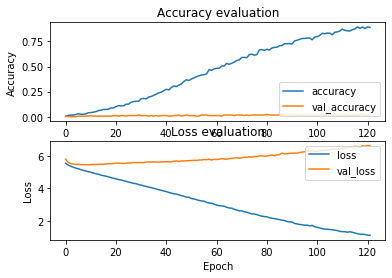

222/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [10]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()


## PROCESING THE TEST SET

In [17]:
#defining our specified variables
DATASET_PATH = "audio_files"
JSON_PATH = "test_nd.json"
SAMPLES_TO_CONSIDER = 22050 # 1 sec. of audio

In [19]:
#Preprocessing test set

def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file.

    :param dataset_path (str): Path to dataset
    :param json_path (str): Path to json file used to save MFCCs
    :param num_mfcc (int): Number of coefficients to extract
    :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
    :param hop_length (int): Sliding window for FFT. Measured in # of samples
    :return:
    """

    # dictionary where we'll store mapping, labels, MFCCs and filenames
    test_new = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }
    
    #looping through the train.csv 
    for i in sample_sub['fn']:
        
        
            
        # load audio file and slice it to ensure length consistency among different files
        signal, sample_rate = librosa.load(i, sr = SAMPLES_TO_CONSIDER)
    

        #drop audio files with less than pre-decided number of samples
        if len(signal) >= SAMPLES_TO_CONSIDER:
           # ensure consistency of the length of the signal
            signal = signal[:SAMPLES_TO_CONSIDER]

#            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                 hop_length=hop_length)
           # store data for analysed track
            test_new["MFCCs"].append(MFCCs.T.tolist())
            test_new["files"].append(i)
            print("{}: {}".format(i, i))
            
#         else:
#             signal = librosa.resample(signal, sample_rate, SAMPLES_TO_CONSIDER)
#             # extract MFCCs
#             MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
#                                                  hop_length=hop_length)
#            # store data for analysed track
#             test_new["MFCCs"].append(MFCCs.T.tolist())
#             test_new["files"].append(i)
#             print("{}: {}".format(i, i))
            
              

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(test_new, fp, indent=4)


if __name__ == "__main__":
    preprocess_dataset(DATASET_PATH, JSON_PATH)   

audio_files/00118N3.wav: audio_files/00118N3.wav
audio_files/00P0NMV.wav: audio_files/00P0NMV.wav
audio_files/01QEEZI.wav: audio_files/01QEEZI.wav
audio_files/037YAED.wav: audio_files/037YAED.wav
audio_files/0382N0Y.wav: audio_files/0382N0Y.wav
audio_files/04S2SS5.wav: audio_files/04S2SS5.wav
audio_files/05KISR5.wav: audio_files/05KISR5.wav
audio_files/066NU27.wav: audio_files/066NU27.wav
audio_files/0773SSN.wav: audio_files/0773SSN.wav
audio_files/07XLAV0.wav: audio_files/07XLAV0.wav
audio_files/096LWLU.wav: audio_files/096LWLU.wav
audio_files/0A4HXK3.wav: audio_files/0A4HXK3.wav
audio_files/0AJPPNQ.wav: audio_files/0AJPPNQ.wav
audio_files/0G2CVFN.wav: audio_files/0G2CVFN.wav
audio_files/0IM8SLP.wav: audio_files/0IM8SLP.wav
audio_files/0K9OULT.wav: audio_files/0K9OULT.wav
audio_files/0KXIZNQ.wav: audio_files/0KXIZNQ.wav
audio_files/0L47WFH.wav: audio_files/0L47WFH.wav
audio_files/0MV7LQS.wav: audio_files/0MV7LQS.wav
audio_files/0N7JNLT.wav: audio_files/0N7JNLT.wav
audio_files/0OTDVG8.

In [75]:
#loading the data
with open('test_nd.json', "r") as fp:
        data = json.load(fp)

        test_set = np.array(data["MFCCs"])
        test_set = test_set[..., np.newaxis] #adding new axis

In [76]:
len(test_set)

1015

In [77]:
#loading model and predicting with  the model
model= tf.keras.models.load_model('model_nd.h5')

In [80]:
test_set.shape

(1015, 44, 13, 1)

In [78]:
#predicting the test set proper
ssd = model.predict(test_set)

In [194]:
#processing and predicting the last 2 rows that didnt reflect/ommited

jui = []
for i in sample_sub['fn'][-2:]:
    
    signal, sample_rate = librosa.load(i, sr = SAMPLES_TO_CONSIDER)
    signal = signal[:SAMPLES_TO_CONSIDER]
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13,n_fft=2048,hop_length=512)
    jui.append(MFCCs.T.tolist())

jui = np.array(jui)
jui= jui[..., np.newaxis] #adding new axis
eer = model.predict(jui)

In [201]:
#Now we join the predicted left-out with the main predicted test_set
ssd = np.append(ssd, eer, axis = 0)

In [202]:
ssd.shape

(1017, 193)

In [203]:
ssd

array([[4.0206225e-03, 1.2293441e-04, 1.3768295e-03, ..., 1.3048913e-02,
        6.1494276e-02, 2.2133935e-02],
       [1.6113098e-03, 9.6709824e-05, 2.1054393e-04, ..., 2.1653091e-04,
        3.2395622e-04, 4.9805222e-04],
       [3.1162050e-04, 3.0750576e-05, 1.0232884e-04, ..., 6.6608563e-04,
        9.0549847e-06, 2.5760193e-04],
       ...,
       [2.6444304e-03, 2.1838346e-04, 2.3392886e-05, ..., 1.6184134e-05,
        9.8242713e-03, 2.3325412e-04],
       [2.8136425e-05, 1.4830919e-04, 7.7256783e-07, ..., 3.9214392e-05,
        2.9187556e-04, 2.4419429e-04],
       [2.6444304e-03, 2.1838346e-04, 2.3392886e-05, ..., 1.6184134e-05,
        9.8242713e-03, 2.3325412e-04]], dtype=float32)

In [204]:
samp = sample_sub.copy()

In [205]:
samp.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,audio_files/00P0NMV.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,audio_files/01QEEZI.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,audio_files/037YAED.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,audio_files/0382N0Y.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
#obtaining column list
wwe=samp.columns

In [207]:
#eliminating the fn column
wwe = wwe[1:]

In [208]:
# creating the dataframe 
df3 = pd.DataFrame(data = ssd,  
                  index = None,  
                  columns = wwe) 

In [209]:
df3.head()

,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,bulimi,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,0.004021,0.000123,0.001377,0.003444,0.010897,0.000076,0.000104,0.000597,0.007410,0.001016,...,0.013112,0.127397,0.004354,0.001432,0.000002,4.320862e-06,0.001210,0.013049,0.061494,0.022134
1,0.001611,0.000097,0.000211,0.000685,0.000465,0.000192,0.000351,0.000160,0.005435,0.010376,...,0.000278,0.000088,0.000076,0.002922,0.000024,5.575551e-05,0.000036,0.000217,0.000324,0.000498
2,0.000312,0.000031,0.000102,0.003649,0.005099,0.001781,0.001577,0.000002,0.002705,0.004252,...,0.000864,0.000076,0.000458,0.001720,0.000007,7.086202e-06,0.000130,0.000666,0.000009,0.000258
3,0.000592,0.000014,0.001691,0.001033,0.004752,0.000051,0.000013,0.000013,0.004707,0.003932,...,0.007397,0.000035,0.000094,0.000484,0.000002,6.319485e-08,0.000011,0.000829,0.000148,0.010406
4,0.000569,0.000016,0.006766,0.001932,0.000372,0.000287,0.001064,0.000179,0.017304,0.002350,...,0.000080,0.000248,0.000035,0.003539,0.000218,2.176438e-06,0.000132,0.004548,0.000343,0.000406


In [210]:
tio = sample_sub['fn']

In [211]:
#now we combine all datasets together
cbd =pd.concat([tio,df3], axis=1)
cbd.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.004021,0.000123,0.001377,0.003444,0.010897,0.000076,0.000104,0.000597,0.007410,...,0.013112,0.127397,0.004354,0.001432,0.000002,4.320862e-06,0.001210,0.013049,0.061494,0.022134
1,audio_files/00P0NMV.wav,0.001611,0.000097,0.000211,0.000685,0.000465,0.000192,0.000351,0.000160,0.005435,...,0.000278,0.000088,0.000076,0.002922,0.000024,5.575551e-05,0.000036,0.000217,0.000324,0.000498
2,audio_files/01QEEZI.wav,0.000312,0.000031,0.000102,0.003649,0.005099,0.001781,0.001577,0.000002,0.002705,...,0.000864,0.000076,0.000458,0.001720,0.000007,7.086202e-06,0.000130,0.000666,0.000009,0.000258
3,audio_files/037YAED.wav,0.000592,0.000014,0.001691,0.001033,0.004752,0.000051,0.000013,0.000013,0.004707,...,0.007397,0.000035,0.000094,0.000484,0.000002,6.319485e-08,0.000011,0.000829,0.000148,0.010406
4,audio_files/0382N0Y.wav,0.000569,0.000016,0.006766,0.001932,0.000372,0.000287,0.001064,0.000179,0.017304,...,0.000080,0.000248,0.000035,0.003539,0.000218,2.176438e-06,0.000132,0.004548,0.000343,0.000406


In [212]:
len(ssd), len(tio)

(1017, 1017)

In [213]:
cbd.to_csv('Sub2.csv', index=False)